<a href="https://colab.research.google.com/github/valentingorce/tp_centrale/blob/main/Day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Information Retrieval
## Introduction to search engines

### DAY 2: Teacher version
### Implementing a search engine

The goal of this second session is to implement a first architecture of a search engine on the previously introduced dataset (stackexchange-datascience). If you missed the first session or if you did not saved the dataset, please reload the first session's notebook to download it. 

If you need some ifnormation about the dataset, it should be available here : https://archive.org/details/stackexchange

The notebook is divided into several steps:
-	Implement the indexation
-	Implement the search method
-	Define a ranking strategy and implement it
-	Suggest some improvements of the search engine



## Initialisation

In [116]:
!pip install ttable
!pip install rank_bm25

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import pandas as pd
import re
import os
import math
import numpy as np
from sklearn.metrics import mean_squared_error
from tt import BooleanExpression
from itertools import product
import numpy as np

In [36]:
# Only if you use Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# TODO:
DATA_PATH = '/content/drive/MyDrive/st4 grp6' 

# Utiliser pandas pour lire le fichier Excel
import pandas as pd

chemin_fichier = '/content/drive/MyDrive/st4 grp6/evaluation_search_engine_post_queries_ranking_EI_CS.xlsx'
df = pd.read_excel(chemin_fichier)

# Afficher les premières lignes du dataframe
df.head()


,PostId,Title,First Sentence,Query 1 : mesure performance for multiclassification model,Query 2 : draw neural network,Query 3 : neural network layers,Query 4 : how sklearn working,Query 5 : treat categorical data
0,6107,What are deconvolutional layers?,I recently read Fully Convolutional Networks f...,NaN,NaN,1.0,NaN,NaN
1,15989,Micro Average vs Macro average Performance in ...,I am trying out a multiclass classification se...,1.0,NaN,NaN,NaN,NaN
2,13490,How to set class weights for imbalanced classe...,I know that there is a possibility in Keras wi...,3.0,NaN,NaN,NaN,NaN
3,12321,What's the difference between fit and fit_tran...,I do not understand the difference between the...,NaN,NaN,NaN,1.0,3.0
4,22,K-Means clustering for mixed numeric and categ...,My data set contains a number of numeric attri...,NaN,NaN,NaN,5.0,2.0


 **Important :**

An Excel file for testing the evaluation part is available in the gitlab repo : evaluation_search_engine_post_queries_ranking_EI_CS.xlsx

If you work on Colab, we advice you to push it directly on your Google Drive directory.

# Implement the indexation
As you might already know, for a search engine to work properly an index of the documents must be created. Here we will keep it in python, and try to use only common libraries to keep it simple.

Once created, the index will be used to match the query with the documents. As a result, there are several ways to build an index, using statistical, boolean, semantic indexation...

First of, let's make a naive one that will consist in breaking down each document into a set of the words it contains.

In [73]:

from nltk.corpus import stopwords
import string
import nltk


def extract_words(text: str) -> list:
    # Remove punctuation
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)

    # Convert to lowercase and split into words
    words = text.lower().split()

    # Remove empty strings
    words = [word for word in words if word]

    # Remove stop words
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Remove duplicates and return as a list
    return list(set(words))



In [74]:

# test
s = "The cat is sat on the mat. The dog is laid on the mat."
assert extract_words(s).sort()==["The","cat","is","sat","on","the","mat.","dog","laid"].sort()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


As you may notice, there are several problems with the previous implementation. First, "The" and "the" aren't considered the same, the "." is kept at the the end of "mat." as any other punctuation character... 

Re-implement this function with some basic preprocessing to avoid these issues.

In [ ]:
import string

def extract_words(text: str) -> list:
    # Remove punctuation
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)

    # Convert to lowercase and split into words
    words = text.lower().split()

    # Remove empty strings
    words = [word for word in words if word]

    # Remove duplicates and return as a list
    return list(set(words))





In [ ]:
s = "The cat is sat on the mat. The dog is laid."
assert sorted(extract_words(s)) == sorted(["the", "cat", "is", "sat", "on", "mat", "dog", "laid"])


Now you sould be able to create your index table. For now we will just make a dataframe with two columns: [raw_text, words].

In [77]:
import pandas as pd

def index_docs(docs: list[str]) -> pd.DataFrame:
    index_table = pd.DataFrame(columns=['raw_text', 'words'])

    for doc in docs:
        words = extract_words(doc)
        index_table = index_table.append({'raw_text': doc, 'words': words}, ignore_index=True)

    return index_table


In [78]:
# test

L = [s, "Hello World!", "Goodbye", "How are you?"]

index_docs(L)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-77-d6c74394a7bd>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  index_table = index_table.append({'raw_text': doc, 'words': words}, ignore_index=True)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-77-d6c74394a7bd>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  index_table = index_table.append({'raw_text': doc, 'words': words}, ignore_index=True)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-77-d6c74394a7bd>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

,raw_text,words
0,The cat is sat on the mat. The dog is laid on ...,"[dog, mat, laid, cat, sat]"
1,Hello World!,"[hello, world]"
2,Goodbye,[goodbye]
3,How are you?,[]


Now, let's try it on the dataset:

In [79]:
import os
import pandas as pd


import codecs

DATA_PATH = "/content/drive/MyDrive/st4 grp6/data"
xml_file = os.path.join(DATA_PATH, "Posts.xml")
cleaned_xml_file = os.path.join(DATA_PATH, "Cleaned_Posts.xml")

with codecs.open(xml_file, 'r', encoding='utf-8', errors='replace') as infile:
    with codecs.open(cleaned_xml_file, 'w', encoding='utf-8') as outfile:
        for line in infile:
            outfile.write(line)

# Now try reading the cleaned file
posts = pd.read_xml(cleaned_xml_file, parser="etree", encoding="utf-8")
# Assuming 'posts' is the DataFrame you created by reading the cleaned XML file
print(posts.head())  # Prints the first few rows of the DataFrame
print(posts.info())  # Prints a summary of the DataFrame, including column names and data types



   Id  PostTypeId             CreationDate  Score  ViewCount  \
0   5           1  2014-05-13T23:58:30.457      9      898.0   
1   7           1  2014-05-14T00:11:06.457      4      478.0   
2   9           2  2014-05-14T00:36:31.077      5        NaN   
3  10           2  2014-05-14T00:53:43.273     13        NaN   
4  14           1  2014-05-14T01:25:59.677     26     1901.0   

                                                Body  OwnerUserId  \
0  <p>I've always been interested in machine lear...          5.0   
1  <p>As a researcher and instructor, I'm looking...         36.0   
2  <p>Not sure if this fits the scope of this SE,...         51.0   
3  <p>One book that's freely available is "The El...         22.0   
4  <p>I am sure data science as will be discussed...         66.0   

          LastActivityDate                                              Title  \
0  2014-05-14T00:36:31.077  How can I do simple machine learning without h...   
1  2014-05-16T13:45:00.237  What open-

For our first version of the indexation mechanism, we will simply use the "body" of the posts. To have a better search engine, the title and other metadata aswell could be used aswell. Finally, not all the XML files have a "body" feature, so for the search engine to retrieve information from any of the files you will need to implement another way to index.

But first, let's start with "body". There is more to preprocess than before, indeed, there are html tags such as "<p>" for instance. They are not useful for us, because users won't use them in their queries. So we first need to remove them.

In [ ]:
from bs4 import BeautifulSoup

def remove_tags(text: str) -> str:
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


In [80]:
# test
remove_tags('<p>Hello World!\nI am making a search engine.<p>')

'Hello World!\nI am making a search engine.'

In [ ]:
clean_posts = posts[['Id','Body']]
clean_posts['Clean Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
clean_posts

<ipython-input-25-c10a303c22ea>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-26-2f3e0e9b59ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['Clean Body'] = clean_posts['Body'].fillna('').apply(remove_tags)


,Id,Body,Clean Body
0,5,<p>I've always been interested in machine lear...,I've always been interested in machine learnin...
1,7,"<p>As a researcher and instructor, I'm looking...","As a researcher and instructor, I'm looking fo..."
2,9,"<p>Not sure if this fits the scope of this SE,...","Not sure if this fits the scope of this SE, bu..."
3,10,"<p>One book that's freely available is ""The El...","One book that's freely available is ""The Eleme..."
4,14,<p>I am sure data science as will be discussed...,I am sure data science as will be discussed in...
...,...,...,...
75722,119962,<p>I am implementing a neural network of arbit...,I am implementing a neural network of arbitrar...
75723,119963,<p>I am using KNN for a regression task</p>\n<...,I am using KNN for a regression task\nIt's lik...
75724,119964,<p>I have developed a small encoding algorithm...,I have developed a small encoding algorithm th...
75725,119965,"<p>To my understanding, optimizing a model wit...","To my understanding, optimizing a model with k..."


In [107]:
clean_posts['words'] = clean_posts['Clean Body'].apply(extract_words)
clean_posts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /ro

KeyboardInterrupt: ignored

## Zipf Law

A way of analyzing a corpus is to draw the zipf law

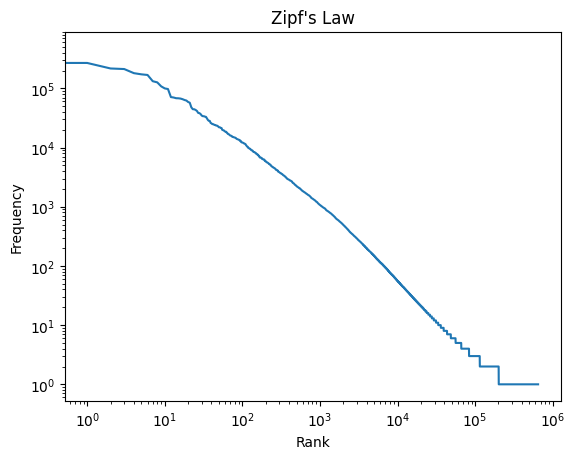

In [75]:
import matplotlib.pyplot as plt
from collections import Counter

# concat all words from 'Clean Body' into one list
all_words = [word for words in clean_posts['Clean Body'] for word in words.split()]

# count occurrences of each word
word_counts = Counter(all_words)

# sort by frequency
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# plot
plt.plot([count for word, count in sorted_word_counts])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Zipf\'s Law')
plt.show()



## Inverted Index

Now, we want to go further on the indexing and build an inverted index. Inverted index is a dictionary where the keys are the words of the vocabulary and the values are the documents containing these words. Reducing the size of the vocabulary is a relevant first step when building an inverted index. Here, we will focus on the creation of the index, we leave you the optimisation steps :)

In [108]:
def create_index(posts: pd.DataFrame) -> dict:
    index = {}

    for i, row in posts.iterrows():
        id = row['Id']
        words = row['words']

        for word in words:
            if word not in index:
                index[word] = {'frequency': 1, 'documents': [id]}
            else:
                index[word]['frequency'] += 1
                index[word]['documents'].append(id)

    # For each word, sort the doc ids and replace them with their differences
    for word, data in index.items():
        docs = data['documents']
        docs.sort()
        for i in range(len(docs) - 1, 0, -1):
            docs[i] = docs[i] - docs[i - 1]
        index[word]['documents'] = docs

    return index



In [110]:
inverted_index = create_index(clean_posts.iloc[0:50])
print(list(inverted_index.items())[:20])

[('simple', {'frequency': 4, 'documents': [5, 30, 8, 14]}), ('generating', {'frequency': 1, 'documents': [5]}), ('if', {'frequency': 20, 'documents': [5, 4, 10, 2, 3, 2, 3, 1, 3, 4, 3, 2, 3, 2, 3, 1, 1, 5, 4, 3]}), ('about', {'frequency': 11, 'documents': [5, 4, 15, 2, 4, 7, 1, 2, 3, 2, 5]}), ('world', {'frequency': 2, 'documents': [5, 25]}), ('example', {'frequency': 11, 'documents': [5, 4, 21, 1, 4, 5, 3, 10, 4, 5, 2]}), ('thing', {'frequency': 1, 'documents': [5]}), ('wanted', {'frequency': 1, 'documents': [5]}), ('hello', {'frequency': 1, 'documents': [5]}), ('for', {'frequency': 36, 'documents': [5, 2, 2, 8, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 4, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 4, 1]}), ('to', {'frequency': 41, 'documents': [5, 2, 2, 5, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 4, 1, 1, 2, 1, 2, 2, 1]}), ('bot', {'frequency': 1, 'documents': [5]}), ('whole', {'frequency': 4, 'documents': [5, 38, 14, 7]}), ('with', {'f

#### Well Done, you've indexed the dataset! 
Don't hesitate to save your indexes in txt or pickle file

---
# Implement the search method

A naive method would be to count the number of words in common between the query and each posts. Then to rank the posts you could directly select the post who maximize the number of common words. Let's implement this approach :

In [98]:
# Implement the word_in_index function 
# Inputs : a word (str) & a list of words
# Output : pandas series of 1 if the word is in the list, else 0

import pandas as pd

def word_in_index(words, word_list_index):
    return pd.Series([1 if word in sublist else 0 for word in words for sublist in word_list_index])


In [99]:
# Implement the function which run through a pandas series and count the number of word in common
# Use extract_words method, apply method with word_in_index function
# Inputs : the query (str) & pandas series of strings
# Output : Pandas series counting the number of common words between the query and each string in word_serie

def count_common_words(query: str, posts: pd.DataFrame) -> pd.Series:
    # Tokenize the query
    query_words = extract_words(query)

    # Check which words in the query are in each post
    word_in_post = posts['words'].apply(lambda words: [word in words for word in query_words])

    # Count the number of True values (common words) in each post
    common_word_counts = word_in_post.apply(sum)

    return common_word_counts


In [100]:
from nltk.corpus import stopwords
import string
def rank_top_query(query: str, df: pd.DataFrame, top: int) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy.loc[:, 'common_word_count'] = count_common_words(query, df_copy)
    ranked_posts = df_copy.sort_values('common_word_count', ascending=False)
    return ranked_posts.head(top)



In [97]:
rank_top_query(query="to find the error delta for c", df=clean_posts, top=5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Id,Body,Clean Body,words,common_word_count,scores
48854,75593,<p>My CNN has the following structure:</p>\n\n...,My CNN has the following structure:\n\nOutput ...,"[its, now, 31212432, 28x28, next, need, biases...",4,0.000000
72899,115761,<p>I am starting with deep learning and decide...,I am starting with deep learning and decided t...,"[someone, neuronoutputweightsiweight, percent,...",4,0.720605
10825,17685,"<p>To make this question answerable, I have to...","To make this question answerable, I have to as...","[way, implementing, by, built, gradients, migh...",4,0.000000
50489,77723,"<p>&quot;To find the error delta for C, I upsa...","""To find the error delta for C, I upsample the...","[now, 28x28, implementing, why, fc, upsampling...",4,0.000000
10180,16856,<p>Nested cross validation estimates the gener...,Nested cross validation estimates the generali...,"[its, now, sklearnmodelselection, about, way, ...",3,0.000000


Testez plusieurs requêtes et critiquez les résultats obtenus.

Quels sont les pros and cons de cette méthodes. Vous l'indiquerez sur le rapport avec vos réflexions pour l'améliorer.

Next, you have to implement the first improvements you find in the search method to get most relevant results 

In [101]:
from nltk.corpus import stopwords
import string

def extract_words(text: str) -> list:
    # Remove punctuation
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)

    # Convert to lowercase and split into words
    words = text.lower().split()

    # Remove empty strings
    words = [word for word in words if word]

    # Remove stop words
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Remove duplicates and return as a list
    return list(set(words))
  

## Boolean Search

Thanks to the ttable library, implement a boolean search method

In [140]:

from tt import BooleanExpression, TruthTable


b = BooleanExpression('(War or France) and (not C)')
print(b)   

b.tree
print(b.tree) 
b.tokens







(War or France) and (not C)
and
`----or
|    `----War
|    `----France
`----not
     `----C


['(', 'War', 'or', 'France', ')', 'and', '(', 'not', 'C', ')']

## Probabilistic search

Implement the MIB or BM25 method of searching

Compare the naive method with your improvements and the boolean and probabilistic search. (report)



---



---




# Evaluate the Search

Now you implement multiple search methods and you're able to improve it. You have to define metric to compare it objectively.



We ask you to implement NDCG (Normalized Discounted Cumulative Gain) from few queries we implement on a dozen of post. We already defined the values of relevance judgement in the xlsx file : . The final score will be the mean quadratic error of the queries.


Explication for the xlsx file :

We propose you a Excel file with some posts and a mesure of relevancy for the queries

- First column is the post Id,
- Columns starting by query are the queries you have to test.
- The values in this columns are the rank of relevancy of the post in regard with the query.
- The missing values indicates you should not take into account the post


You will have to criticize this metric and your result in the report. Then you will have to propose some improvements. 

Thereafter in this week, you will have to compare your different search engines.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AssertionError: ignored

In [ ]:
def calculate_ndgc(query_col="query", output_col="query_output"):
  # TODO

  return


# Read Relevancy CSV
df_relevancy = pd.read_excel("/content/drive/MyDrive/TP Centrale/evaluation_search_engine_post_queries_ranking_EI_CS.xlsx")
